In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [2]:
!kaggle datasets download -d felicepollano/watermarked-not-watermarked-images
!unzip watermarked-not-watermarked-images

Streaming output truncated to the last 5000 lines.
  inflating: wm-nowm/valid/no-watermark/pexels-photo-3535082.jpeg  
  inflating: wm-nowm/valid/no-watermark/pexels-photo-3535630.jpeg  
  inflating: wm-nowm/valid/no-watermark/pexels-photo-3536072.jpeg  
  inflating: wm-nowm/valid/no-watermark/pexels-photo-3536235.jpeg  
  inflating: wm-nowm/valid/no-watermark/pexels-photo-3536271.jpeg  
  inflating: wm-nowm/valid/no-watermark/pexels-photo-3536293.jpeg  
  inflating: wm-nowm/valid/no-watermark/pexels-photo-3536426.jpeg  
  inflating: wm-nowm/valid/no-watermark/pexels-photo-3536516.jpeg  
  inflating: wm-nowm/valid/no-watermark/pexels-photo-3539894.jpeg  
  inflating: wm-nowm/valid/no-watermark/pexels-photo-3539898.jpeg  
  inflating: wm-nowm/valid/no-watermark/pexels-photo-3544555.jpeg  
  inflating: wm-nowm/valid/no-watermark/pexels-photo-3546189.jpeg  
  inflating: wm-nowm/valid/no-watermark/pexels-photo-354941.jpeg  
  inflating: wm-nowm/valid/no-watermark/pexels-photo-3551217.jpeg 

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
import os

from tensorflow.keras import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout

In [11]:
# Load the training and validation datasets
batch_size = 32
img_size = (256, 256)
NUM_IMAGES = 3000

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/wm-nowm/train',
    labels='inferred',
    label_mode='int',
    batch_size=batch_size,
    image_size=img_size,
    shuffle=True
)

validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/wm-nowm/valid',
    labels='inferred',
    label_mode='int',
    batch_size=batch_size,
    image_size=img_size
)


# Optional: Normalize images to range [0, 1]
train_ds = train_ds.map(lambda x, y: (x / 255.0, y))
validation_ds = validation_ds.map(lambda x, y: (x / 255.0, y))

subset_size = NUM_IMAGES // batch_size
train_ds = train_ds.take(subset_size)
validation_ds = validation_ds.take(subset_size)


Found 24987 files belonging to 2 classes.
Found 6588 files belonging to 2 classes.


In [5]:
from tensorflow.keras.applications import VGG16
conv_base = VGG16(
    weights='imagenet',
    include_top = False,
    input_shape=(256,256,3)
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [6]:

from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input

# Define the input shape
input_shape = (256, 256, 3)

# Define the model with an explicit input layer
model = models.Sequential([
    Input(shape=input_shape),
    VGG16(weights='imagenet', include_top=False, input_shape=input_shape),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Binary output for watermark detection
])

# Freeze the VGG16 layers to avoid retraining
model.layers[1].trainable = False  # The VGG16 model is at index 1 here

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary to verify the structure
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 8, 8, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       8,388,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,103,809 (88.13 MB)

 Trainable params: 23,103,809 (88.13 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
conv_base.trainable = True

set_trainable = False

for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

for layer in conv_base.layers:
  print(layer.name,layer.trainable)

input_layer False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


In [8]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [12]:
history = model.fit(train_ds,epochs=10,validation_data=validation_ds)

Epoch 1/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 85s 916ms/step - accuracy: 0.4810 - loss: 0.6939 - val_accuracy: 0.4933 - val_loss: 0.6933
Epoch 2/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 66s 715ms/step - accuracy: 0.5082 - loss: 0.6931 - val_accuracy: 0.4953 - val_loss: 0.6934
Epoch 3/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 66s 715ms/step - accuracy: 0.5098 - loss: 0.6930 - val_accuracy: 0.4933 - val_loss: 0.6934
Epoch 4/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 67s 716ms/step - accuracy: 0.5109 - loss: 0.6930 - val_accuracy: 0.4956 - val_loss: 0.6934
Epoch 5/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 67s 717ms/step - accuracy: 0.5105 - loss: 0.6930 - val_accuracy: 0.4882 - val_loss: 0.6937
Epoch 6/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 66s 715ms/step - accuracy: 0.5077 - loss: 0.6930 - val_accuracy: 0.4923 - val_loss: 0.6937
Epoch 7/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 66s 715ms/step - accuracy: 0.5108 - loss: 0.6929 - val_accuracy: 0.4903 - val_loss: 0.6936
Epoch 8/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 67s 717ms/step - accuracy: 0.5054 - loss: 0.6931 - val_accu

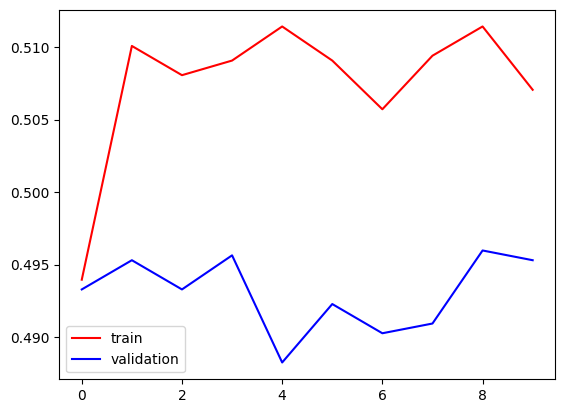

In [13]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

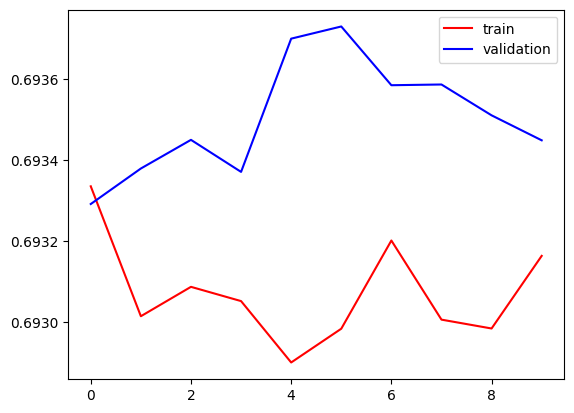

In [14]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()